In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import os
from PIL import Image
import requests
from io import BytesIO
from joblib import Parallel, delayed

from glob import glob
from tqdm import tqdm

from itertools import chain
from collections import Counter

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import find_boundaries
import skimage

import scipy.ndimage

In [3]:
import sys

sys.path.append('..')
from src.configs import config
%load_ext autoreload
%autoreload 2

In [4]:
#from https://www.proteinatlas.org/download/subcellular_location.tsv.zip
# subcellular_location = pd.read_csv('../data/csv/subcellular_location.tsv', sep="\t",index_col = None)
# subcellular_location.tail()

In [5]:
import cv2


import sys
sys.path.append('..')
from src.configs import config

In [6]:
def label_cells(image):
    
    # Find the small dense regions in the image (cells)
    centroids = image[..., 2] > 10
    roi = np.logical_not(centroids)
    # distances = cv2.distanceTransform((roi).astype(np.uint8), cv2.DIST_L2,5)
    # roi = scipy.ndimage.binary_opening(roi, iterations=10)

    # Label each of the regions
    labels, _ = scipy.ndimage.label(centroids)

    # Ignore regions which are too small
    for colour in np.where(np.bincount(labels.flatten()) < 250)[0]:
        labels[labels == colour] = 0

    # Flatten the image in a grayscale and expand the labeled regions using
    # watershed (ignoring the black background)
    pools = image.astype(np.float).sum(-1)
    watershed = skimage.morphology.watershed(-pools, labels, mask=pools > 1)
    
    # Colorize the output
    colours = np.unique(watershed)
    colours = colours[colours != 0]
    for i, colour in enumerate(colours):
        watershed[watershed == colour] = i + 1
    return watershed

In [91]:
roi_ids = config.labels[config.labels['Rods & rings'] != 0].Id

AttributeError: module 'src.configs.config' has no attribute 'labels'

In [92]:
idx = np.random.choice(roi_ids)
idx

NameError: name 'roi_ids' is not defined

In [8]:
image = cv2.imread('../data/train_shrinked/{}_blue_red_green.png'.format(idx))
mask = cv2.imread('../data/train_shrinked/{}_mask.png'.format(idx), -1)

watershed = label_cells(image)
plt.figure(figsize=(10, 10))
plt.imshow(image)

plt.figure(figsize=(10, 10))
plt.imshow(mask)

plt.figure(figsize=(10, 10))
a = plt.imshow(watershed)
plt.colorbar(a)

NameError: name 'idx' is not defined

In [ ]:
for i, idx in tqdm(enumerate(config.labels.Id.values)):
    image = cv2.imread('../data/train_shrinked/{}_blue_red_green.png'.format(idx))

    watershed = label_cells(image)
    cv2.imwrite('../data/external_masks/{}_mask.png'.format(idx), watershed.astype(np.uint16))

    if i % 1000 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(image)

        mask = cv2.imread('../data/train_shrinked/{}_mask.png'.format(idx), -1)
        if mask is not None:
            plt.figure(figsize=(10, 10))
            plt.imshow(mask)
            

        watershed = cv2.imread('../data/external_masks/{}_mask.png'.format(idx), -1)
        plt.figure(figsize=(10, 10))
        plt.imshow(watershed)
        plt.show()

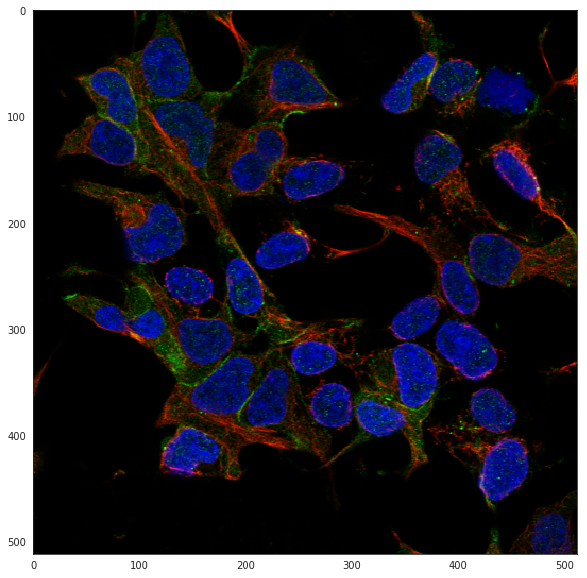

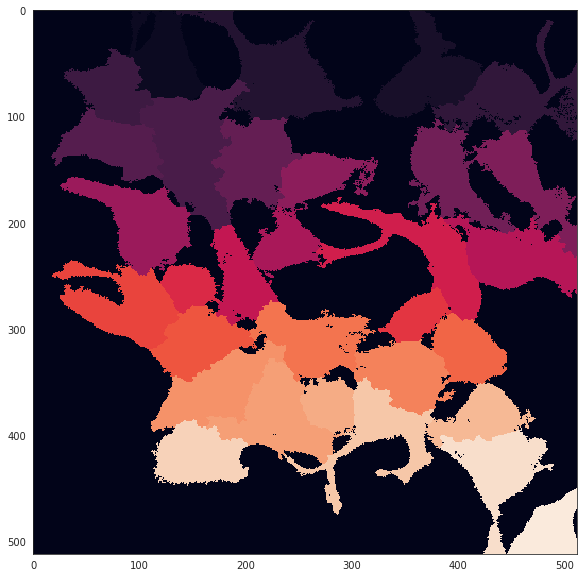

11702it [17:08, 11.38it/s]


In [18]:
root_dir = '../data/test_shrinked'
mask_dir = '../data/external_masks'
template = os.path.join(root_dir, '*_blue_red_green.png')

for i, idx in tqdm(enumerate(glob(template))):
    mask_path = os.path.join(mask_dir, os.path.basename(idx.replace('_blue_red_green', '_mask')))
    image = cv2.imread(idx)

    watershed = label_cells(image)
    cv2.imwrite(mask_path, watershed.astype(np.uint16))

    if i % 1000 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(image)

        watershed = cv2.imread(mask_path, -1)
        plt.figure(figsize=(10, 10))
        plt.imshow(watershed)
        plt.show()

In [30]:
import shutil

for path in glob('../data/models/resnet50_pure/*predicts_fold_*'):
    print(path)
    shutil.move(path, path.replace('predicts', 'predicts_old'))

for path in glob('../data/models/resnet50_pure/*keys_fold_*'):
    print(path)
    shutil.move(path, path.replace('keys', 'keys_old'))

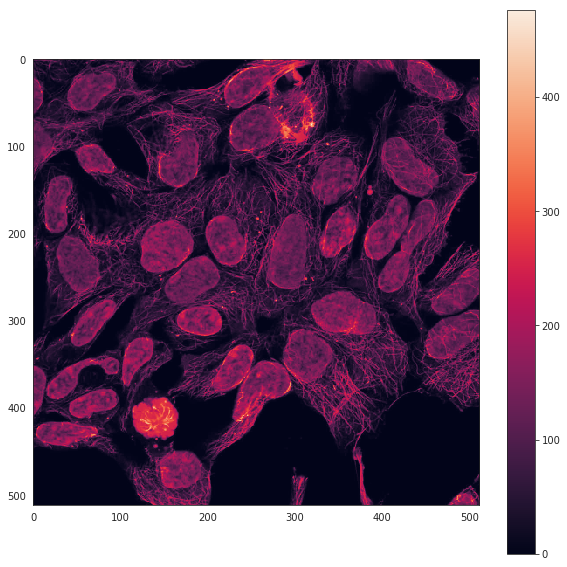

In [12]:
image = cv2.imread('../data/train_shrinked/{}_blue_red_green.png'.format(idx))
# image = np.clip(image, 0, 10)

plt.figure(figsize=(10, 10))
a = plt.imshow(image[..., ].sum(2))
plt.colorbar(a)

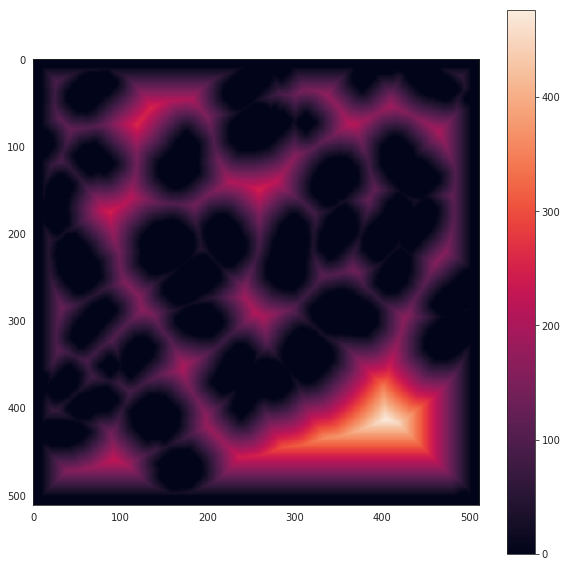

In [13]:
import scipy.ndimage


centroids = image[..., 2] > 10
roi = np.logical_not(centroids)
roi = scipy.ndimage.binary_closing(roi, iterations=10)
# distances = scipy.ndimage.distance_transform_edt(roi)
distances = cv2.distanceTransform((roi).astype(np.uint8), cv2.DIST_L2,5)

plt.figure(figsize=(10, 10))
plt.imshow(distances)
plt.colorbar(a)

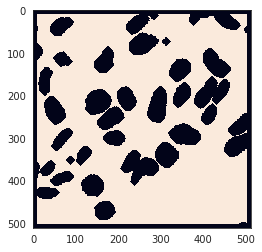

In [14]:
plt.imshow(roi)

/home/vessemer/anaconda3/envs/cxr/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


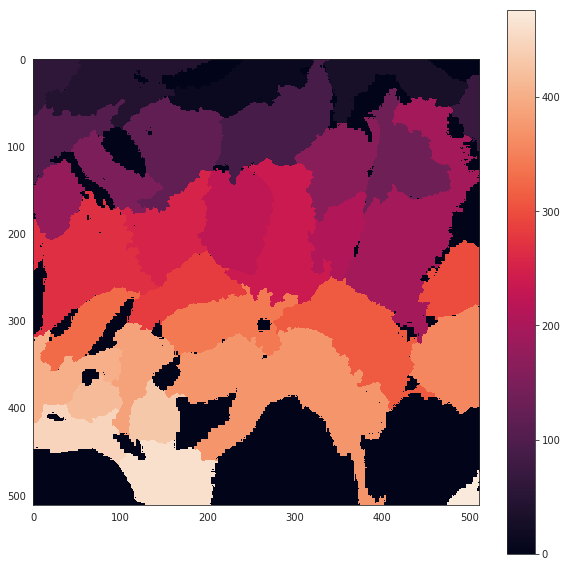

In [22]:
labels, _ = scipy.ndimage.label(centroids)

for colour in np.where(np.bincount(labels.flatten()) < 250)[0]:
    labels[labels == colour] = 0

watershed = skimage.morphology.watershed(-image.astype(np.float).sum(2), labels, mask=image[..., 0] > 1)

colours = np.unique(watershed)
colours = colours[colours != 0]
for i, colour in enumerate(colours):
    watershed[watershed == colour] = i + 1

plt.figure(figsize=(10, 10))
plt.imshow(watershed)
plt.colorbar(a)

In [64]:

coords = np.array(np.where(labels)).T
centroid = coords[np.random.randint(len(coords))]
centroid = np.clip(centroid, 122 // 2, np.array(labels.shape) - 122 // 2)
centroid

array([ 88, 383])

In [70]:
np.expand_dims(hr_image, -1).shape

(512, 512, 1)

In [76]:
from PIL import Image

hr_image = np.stack([ 
    cv2.imread(paths[0].format(colour), -1) 
    for colour in ['blue', 'red', 'green', 'yellow']
], axis=-1).mean(-1).astype(np.uint8)
hr_image = Image.fromarray(hr_image)
hr_image.shape

AttributeError: 'Image' object has no attribute 'shape'

In [13]:
import scipy.ndimage

def segment_cells(paths, dataset_type='hpa'):
    for path in tqdm(paths):
        
        if dataset_type == 'hpa':
            image = np.stack([ 
                cv2.imread(path.format(colour), -1) for colour in ['blue', 'red', 'green']
            ], axis=-1)
        elif dataset_type == 'rx':
            image = np.stack([
                cv2.imread(path.format('w'+str(ch))) for ch in range(1, 4)
            ], axis=-1)
        else:
            raise ValueError('Unknown dataset type ' + dataset_type)

        centroids = image[..., 0] > 10
        roi = np.logical_not(centroids)
        roi = scipy.ndimage.binary_closing(roi, iterations=10)
        # distances = scipy.ndimage.distance_transform_edt(roi)
        # distances = cv2.distanceTransform((roi).astype(np.uint8), cv2.DIST_L2, 5)

        labels, _ = scipy.ndimage.label(centroids)

        for colour in np.where(np.bincount(labels.flatten()) < 250)[0]:
            labels[labels == colour] = 0

        watershed = skimage.morphology.watershed(-image.astype(np.float).sum(2), labels, mask=image[..., 2] > 1)
        labels = skimage.morphology.watershed(-image.astype(np.float).sum(2), labels, mask=image[..., 0] > 1)

        colours = np.unique(watershed)
        colours = colours[colours != 0]
        for i, colour in enumerate(colours):
            watershed[watershed == colour] = i + 1

        cv2.imwrite(path.format('centroids_masks'), labels.astype(np.uint16))
        cv2.imwrite(path.format('cells_masks'), watershed.astype(np.uint16))


In [47]:
paths = glob(str(config.PATHS.TRAIN/'*_red.png'))
paths = [ p.replace('_red.png', '_{}.png') for p in paths ]
segment_cells(paths)

100%|██████████| 30872/30872 [1:10:26<00:00,  7.91it/s]


In [48]:
paths = glob(str(config.PATHS.VALID/'*_red.png'))
paths = [ p.replace('_red.png', '_{}.png') for p in paths ]
segment_cells(paths)

100%|██████████| 25/25 [00:02<00:00,  8.87it/s]


In [8]:
def rec_mk_img_paths(row, prefix):
    return [(prefix + '/{}/Plate{}/{}_s{}_*.png')
            .format(row['experiment'], row['plate'], row['well'], site)
            .replace('*', '{}')
            for site in [1, 2]]

In [14]:
train_tbl = pd.read_csv('../data/recursion/train.csv')
rx_paths = []
for (idx, row) in train_tbl.iterrows():
    rx_paths += rec_mk_img_paths(row, '../data/recursion/train')

segment_cells(rx_paths, dataset_type='rx')

  0%|          | 227/72700 [06:14<32:43:20,  1.63s/it]

KeyboardInterrupt: 

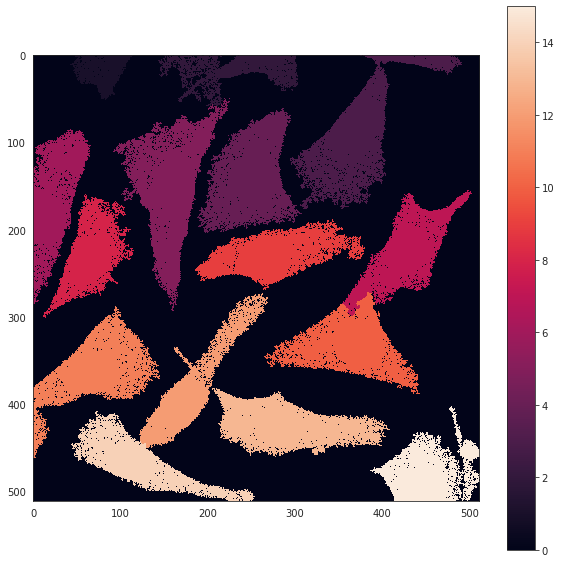

In [44]:
plt.figure(figsize=(10, 10))
a = plt.imshow(watershed)
plt.colorbar(a)

In [21]:
np.unique(watershed)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int32)

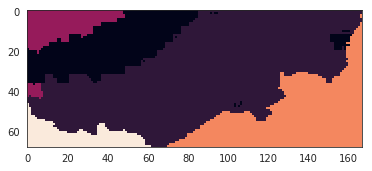

In [24]:
colour = 1
roi = watershed == colour
coords = np.array(np.where(roi))
x_min, y_min = coords[0].min(), coords[1].min()
x_max, y_max = coords[0].max(), coords[1].max()
plt.imshow(watershed[x_min: x_max, y_min: y_max])

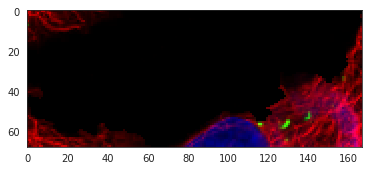

In [25]:
kernel = (watershed[x_min: x_max, y_min: y_max] == colour).astype(np.uint8)

crop = image[x_min: x_max, y_min: y_max] * np.expand_dims(np.logical_not(kernel), -1)
plt.imshow(crop)

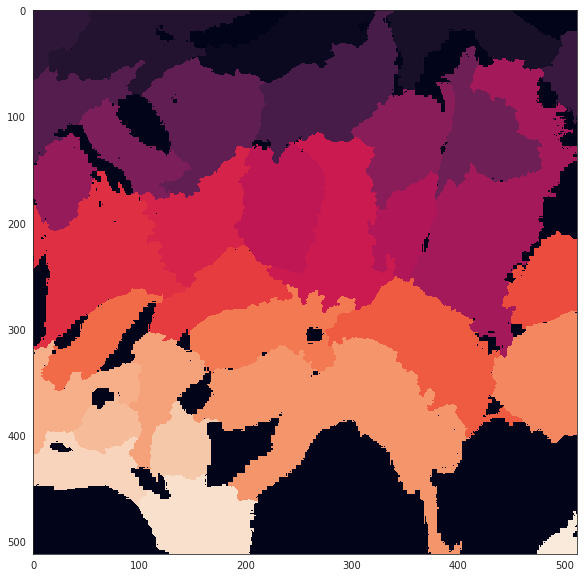

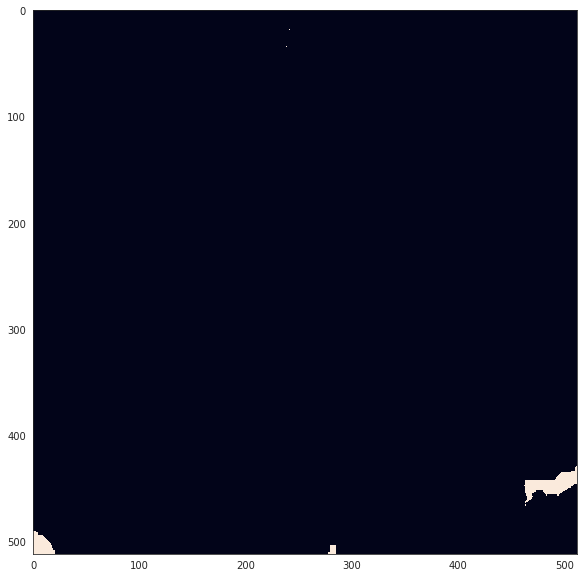

In [26]:
import cv2
import numpy as np


roi_rest = ((watershed == 0) | roi).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(watershed)
plt.show()

placeholder = cv2.erode(roi_rest, kernel, iterations=1)

plt.figure(figsize=(10, 10))
plt.imshow(placeholder)
plt.show()

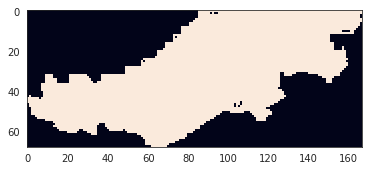

In [27]:
plt.imshow(kernel)

In [35]:
watershed[x_min: x_max, y_min: y_max].shape

(68, 167)

In [314]:
coords[1, idx] - y_len

285

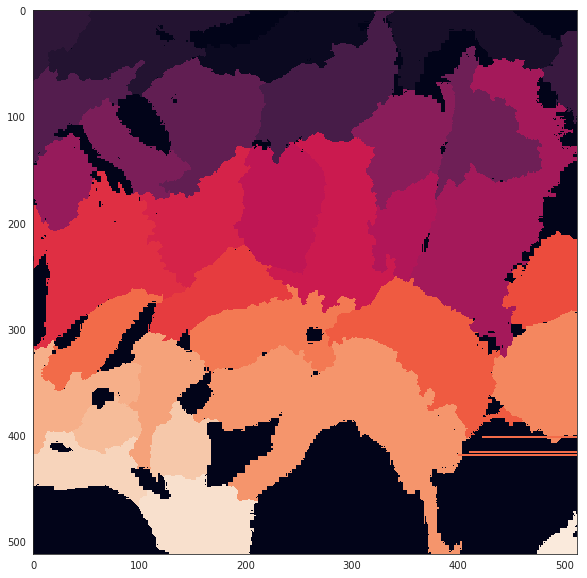

In [42]:
coords = np.array(np.where(placeholder))
idx = np.random.randint(coords.shape[1])

x_min, y_min = max(coords[0, idx] - x_len, 0), max(coords[1, idx] - y_len, 0)
x_max, y_max = coords[0, idx] + x_len, coords[1, idx] + y_len
coords[:, idx]

x_len, y_len = (x_max - x_min) // 2, (y_max - y_min) // 2
watershed[coords[0, idx] - x_len: coords[0, idx] + x_len, coords[1, idx] - y_len: coords[1, idx] + y_len][kernel] = 22
plt.figure(figsize=(10, 10))
plt.imshow(watershed)


In [44]:
img = image.copy()
fingerprint = np.logical_not(kernel)
img[coords[0, idx]: coords[0, idx] + x_max - x_min, coords[1, idx]: coords[1, idx] + y_max - y_min][fingerprint] = crop[fingerprint]
plt.figure(figsize=(10, 10))
plt.imshow(img)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 63 but corresponding boolean dimension is 68

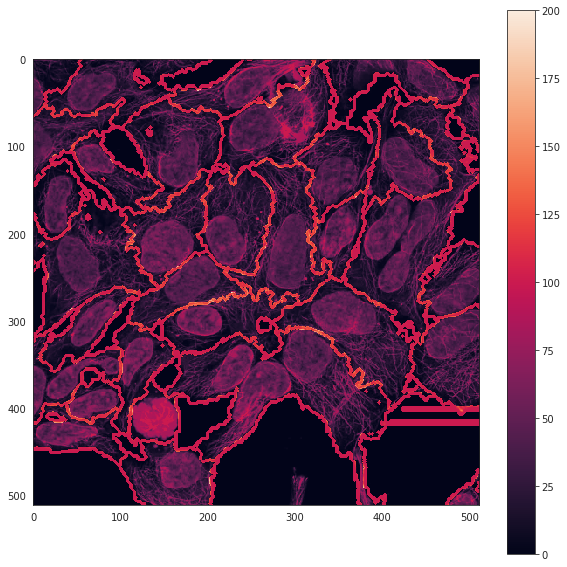

In [45]:
full = image.mean(axis=2)
full = np.clip(full, 0, 100)


boundaries = find_boundaries(watershed)
boundaries = scipy.ndimage.binary_dilation(boundaries, iterations=1)
plt.figure(figsize=(10, 10))
a = plt.imshow(full + boundaries * 100)
plt.colorbar(a)


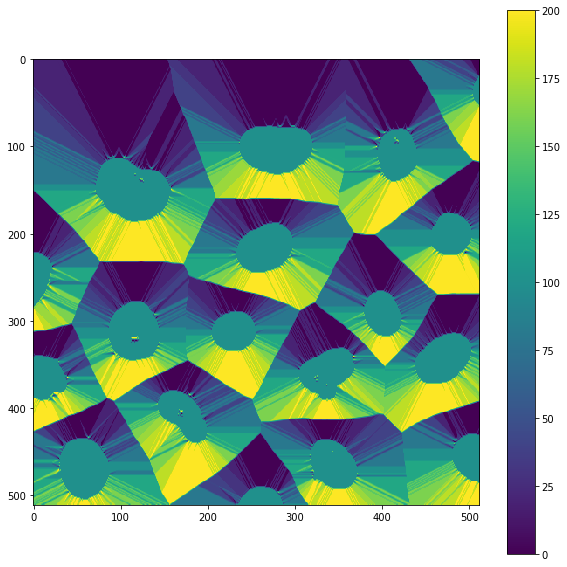

In [44]:
gradient = np.gradient(distances)

plt.figure(figsize=(10, 10))
plt.imshow(gradient[0])
plt.colorbar(a)

In [45]:
image = cv2.imread('../data/external_data/ENSG00000000003-TSPAN6_0.png')

plt.figure(figsize=(10, 10))
a = plt.imshow(image[..., 1])
plt.colorbar(a)

TypeError: 'NoneType' object is not subscriptable

<Figure size 720x720 with 0 Axes>

In [218]:
colours = ['blue', 'green', 'red']
root_dir = '../data/external_data'

for path in tqdm(glob(os.path.join(root_dir, '*.png'))):
    name = os.path.basename(path)[:-4]
    image = cv2.imread(path)
    for i, el in enumerate(colours):
        save_path = os.path.join(root_dir, '{}_{}.{}'.format(name, el, 'png'))
        cv2.imwrite(save_path, image[..., i])


100%|██████████| 14230/14230 [18:08<00:00, 13.08it/s]


In [219]:
save_path

'../data/external_data/ENSG00000189060-H1F0_0_red.png'

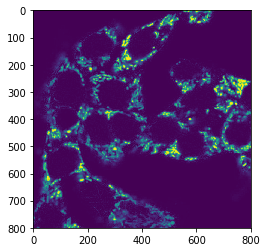

In [217]:
plt.imshow(image[..., 1])

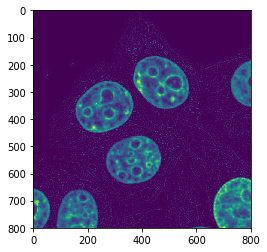

In [224]:
plt.imshow(cv2.imread('../data/external_data/ENSG00000001631-KRIT1_0_blue.png', 0))